In [2]:
import sys
import seaborn as sb
import numpy as np
from itertools import product, combinations
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, completeness_score 
from sklearn.metrics import v_measure_score, adjusted_rand_score
from sklearn.metrics import silhouette_score

In [3]:
origin = pd.read_excel("http://data.hossam.kr/G02/traffic.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   발생년         2658 non-null   int64         
 1   발생년월일시      2658 non-null   datetime64[ns]
 2   주야          2658 non-null   object        
 3   요일          2658 non-null   object        
 4   사망자수        2658 non-null   int64         
 5   부상자수        2658 non-null   int64         
 6   중상자수        2658 non-null   int64         
 7   경상자수        2658 non-null   int64         
 8   부상신고자수      2658 non-null   int64         
 9   발생지시도       2658 non-null   object        
 10  발생지시군구      2658 non-null   object        
 11  사고유형_대분류    2658 non-null   object        
 12  사고유형_중분류    2658 non-null   object        
 13  사고유형        2658 non-null   object        
 14  가해자법규위반     2658 non-null   object        
 15  도로형태_대분류    2658 non-null   object        
 16  도로형태        2658 non-nul

,발생년,발생년월일시,주야,요일,사망자수,부상자수,중상자수,경상자수,부상신고자수,발생지시도,...,사고유형,가해자법규위반,도로형태_대분류,도로형태,가해자_당사자종별,피해자_당사자종별,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
0,2022,2022-01-01 10:00:00,주,토,1,0,0,0,0,전남,...,공작물충돌,안전운전 의무 불이행,단일로,교량위,승용차,없음,1000059,1660526,127.500646,34.939564
1,2022,2022-01-01 14:00:00,주,토,1,0,0,0,0,전북,...,추돌,안전운전 의무 불이행,단일로,기타단일로,원동기장치자전거,승용차,965929,1760951,127.122710,35.844490
2,2022,2022-01-01 17:00:00,주,토,1,0,0,0,0,경기,...,도로이탈 추락,안전운전 의무 불이행,단일로,기타단일로,이륜차,없음,966667,2021002,127.119365,38.188669
3,2022,2022-01-01 20:00:00,야,토,1,0,0,0,0,부산,...,기타,안전운전 의무 불이행,단일로,고가도로위,승용차,승용차,1156990,1697307,129.225773,35.258920
4,2022,2022-01-02 06:00:00,주,일,1,0,0,0,0,서울,...,횡단중,안전운전 의무 불이행,단일로,기타단일로,승합차,보행자,950217,1953529,126.936182,37.579800


## 03.데이터 전처리

#### 필요한 데이터만 추출

In [4]:
df = origin.query("발생지시도 == '서울' and 사망자수 > 0")
print(df.shape)
df.tail()

(215, 23)


,발생년,발생년월일시,주야,요일,사망자수,부상자수,중상자수,경상자수,부상신고자수,발생지시도,...,사고유형,가해자법규위반,도로형태_대분류,도로형태,가해자_당사자종별,피해자_당사자종별,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
2628,2022,2022-12-26 11:00:00,주,월,1,0,0,0,0,서울,...,횡단중,보행자 보호의무 위반,교차로,교차로내,이륜차,보행자,963582,1956027,127.087419,37.602941
2636,2022,2022-12-27 13:00:00,주,화,1,0,0,0,0,서울,...,횡단중,안전운전 의무 불이행,기타,기타,화물차,보행자,955854,1947532,127.000383,37.526035
2644,2022,2022-12-28 09:00:00,주,수,1,0,0,0,0,서울,...,차도통행중,안전운전 의무 불이행,교차로,교차로내,승용차,보행자,959136,1942519,127.037804,37.481003
2649,2022,2022-12-29 15:00:00,주,목,2,3,3,0,0,서울,...,공작물충돌,안전운전 의무 불이행,단일로,기타단일로,승용차,없음,945760,1946547,126.886223,37.516619
2655,2022,2022-12-30 23:00:00,야,금,1,1,0,1,0,서울,...,측면충돌,신호위반,교차로,교차로내,승용차,승합차,953659,1945091,126.975696,37.503926


#### 군집에 사용할 데이터를 표준화

In [5]:
x = df[['경도', '위도']]
scaler = StandardScaler()
n_data = scaler.fit_transform(x)
n_data[:5]

array([[-0.49295687,  0.81624643],
       [-0.88651335, -0.68436506],
       [-0.0892039 , -1.17366995],
       [-0.00405861, -1.32094612],
       [ 0.37764499,  0.11784443]])

## 04. sorted-k-dist 그래프

In [6]:
neighbors = NearestNeighbors(n_neighbors =4)
neighbors_fit = neighbors.fit(n_data)
dist, indi = neighbors_fit.kneighbors(n_data)
s_dist = np.sort(dist, axis = 0)

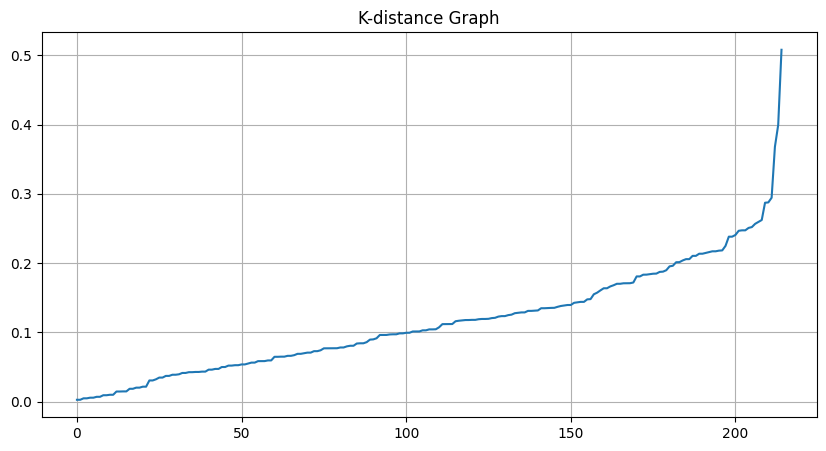

In [7]:
plt.figure(figsize=(10,5))
plt.plot(s_dist[:,1])
plt.grid()
plt.title('K-distance Graph')
plt.show()
plt.close()

## 05. DBSCAN 모델 구축

### 1. 조건값 설정


In [8]:
eps = [0.2, 0.3]
minPts = [4, 5]

eps= 0.2 min_samples= 4
cluster label: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
silhouette_score:  0.0745649278380411


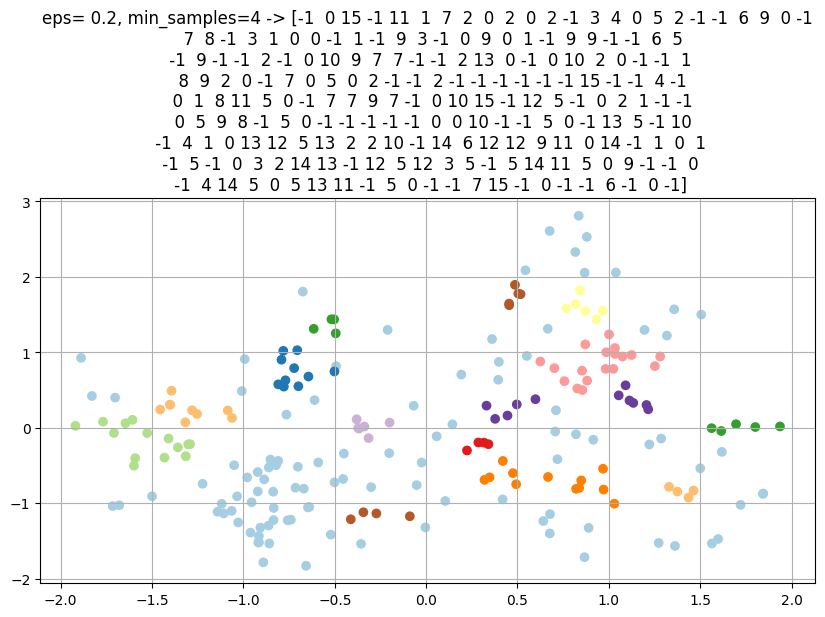

eps= 0.2 min_samples= 5
cluster label: [-1  0  1  2  3  4  5  6  7  8  9 10]
silhouette_score:  -0.03013095514857546


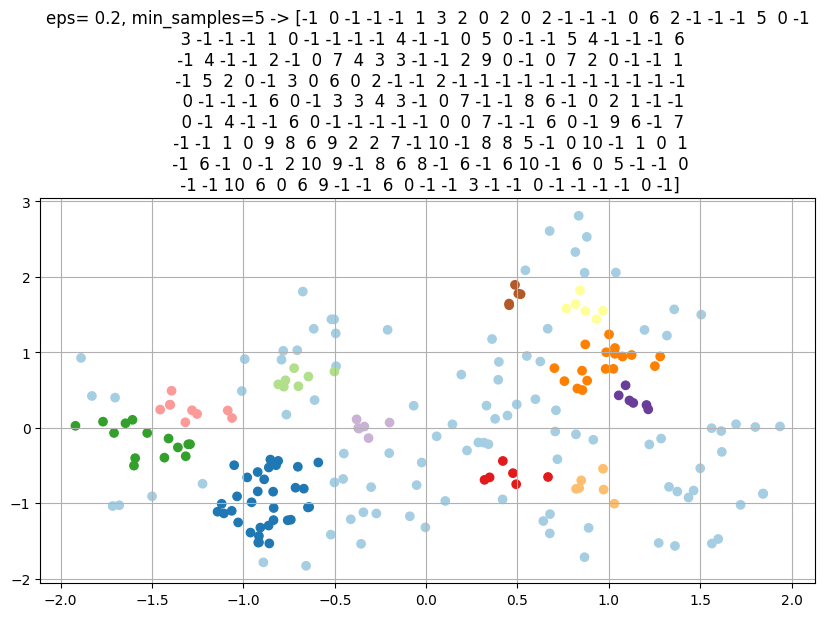

eps= 0.3 min_samples= 4
cluster label: [-1  0  1  2  3  4  5  6  7]
silhouette_score:  0.1304766568733151


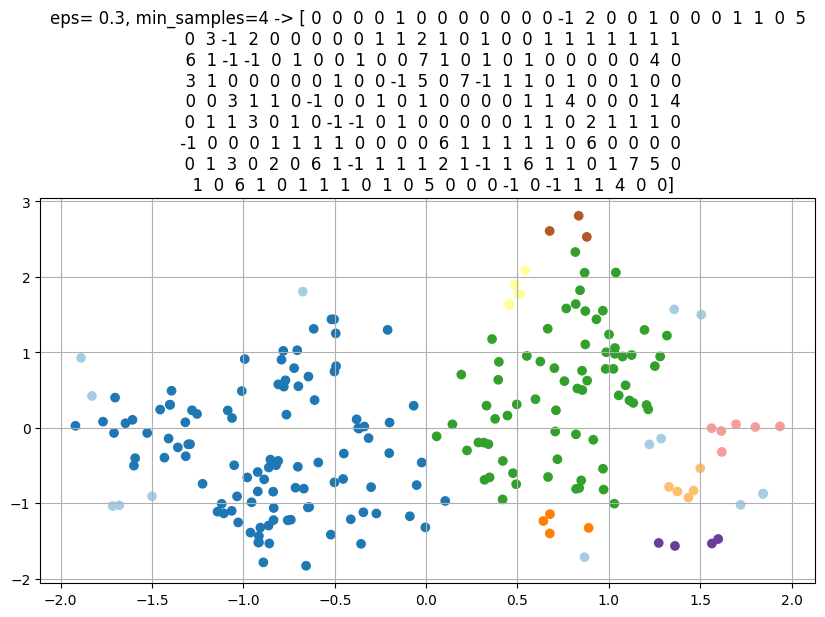

eps= 0.3 min_samples= 5
cluster label: [-1  0  1  2  3  4  5  6]
silhouette_score:  -0.11868242696621047


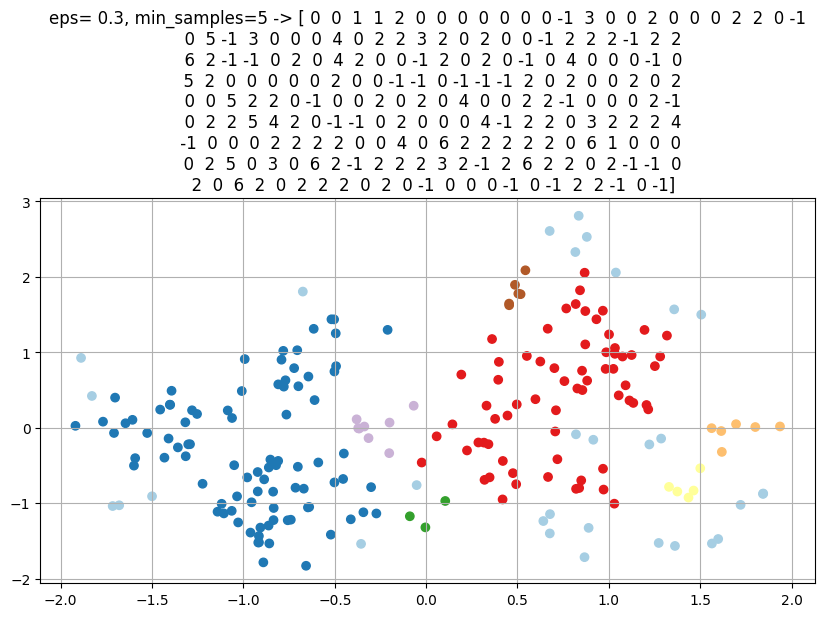

In [9]:
for e , m in list(product(*[eps, minPts])) :
    dbscan = DBSCAN(eps = e, min_samples = m)
    clusters = dbscan.fit_predict(n_data)
    print('eps=', e, 'min_samples=', m)
    print("cluster label:", np.unique(clusters))
    print('silhouette_score: ', silhouette_score(n_data, clusters))

    plt.figure(figsize=(10,5))
    plt.scatter(n_data[:, 0], n_data[:, 1], c=clusters, cmap = "Paired")
    plt.grid()
    plt.title("eps= %s, min_samples=%s -> %s" % (str(e), str(m), clusters))
    plt.show()
    plt.close()
    plt.close()

## 06. 최종 모델 선정

> eps = 0.2, min_samples = 4

In [10]:
dbscan = DBSCAN(eps = 0.2, min_samples = 4, n_jobs = 1)
clusters = dbscan.fit_predict(n_data)
clusters[:5]

array([-1,  0, 15, -1, 11], dtype=int64)

### 핵심포인트 얻기

In [11]:
core_sample_indices = dbscan.core_sample_indices_
core_sample_indices

array([  1,   5,   8,   9,  10,  11,  13,  14,  15,  16,  17,  20,  22,
        24,  25,  28,  29,  34,  35,  37,  38,  39,  40,  42,  43,  46,
        47,  49,  52,  54,  55,  56,  57,  58,  61,  63,  65,  66,  67,
        68,  71,  72,  73,  75,  77,  78,  79,  80,  84,  94,  96,  98,
        99, 100, 103, 106, 108, 109, 112, 113, 116, 120, 122, 123, 125,
       126, 132, 133, 134, 137, 138, 140, 143, 145, 146, 147, 148, 149,
       150, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 165,
       166, 167, 169, 171, 172, 173, 174, 175, 178, 179, 183, 184, 185,
       186, 187, 191, 193, 196, 197, 201, 202, 206, 208, 211, 213],
      dtype=int64)

### 학습 데이터 중에서 핵심 포인트의 인덱스와 일치하는 데이터 찾기

In [12]:
is_core_samples = []

for i in range(0,n_data.shape[0]):
    if i in core_sample_indices:
        is_core_samples.append(1)
    else:
        is_core_samples.append(0)

print(is_core_samples)

[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


### 결과 시각화

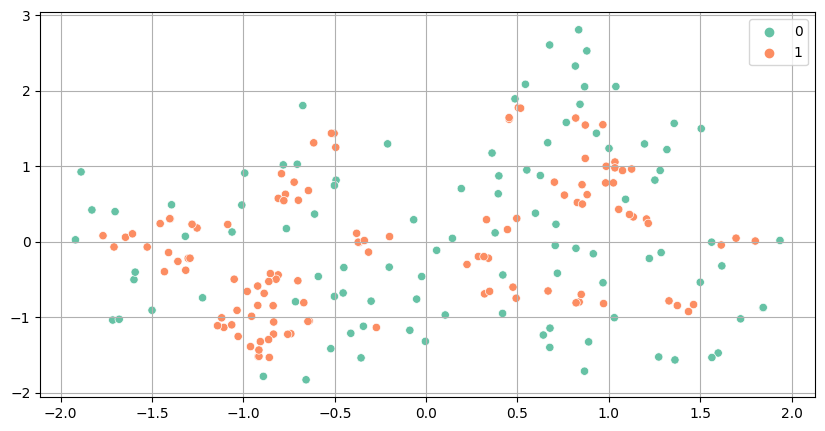

In [13]:
plt.figure(figsize= (10,5))
sb.scatterplot(x=n_data[:,0], y =n_data[:,1],
                hue =is_core_samples, palette = "Set2")
plt.grid()
plt.show()
plt.close()

## 06. 분석결과

In [14]:
result_df = df.filter(['발생지시도', '발생지시군구', '사고유형', 
                           '가해자법규위반', '도로형태_대분류','가해자_당사자종별', '피해자_당사자종별',
                            '경도', '위도' ])
result_df

,발생지시도,발생지시군구,사고유형,가해자법규위반,도로형태_대분류,가해자_당사자종별,피해자_당사자종별,경도,위도
4,서울,서대문구,횡단중,안전운전 의무 불이행,단일로,승합차,보행자,126.936182,37.579800
11,서울,영등포구,횡단중,안전운전 의무 불이행,단일로,승용차,보행자,126.900927,37.507591
20,서울,동작구,차도통행중,안전운전 의무 불이행,교차로,승용차,보행자,126.972351,37.484045
22,서울,동작구,횡단중,보행자 보호의무 위반,단일로,건설기계,보행자,126.979979,37.476959
31,서울,성동구,횡단중,신호위반,단일로,이륜차,보행자,127.014172,37.546193
...,...,...,...,...,...,...,...,...,...
2628,서울,중랑구,횡단중,보행자 보호의무 위반,교차로,이륜차,보행자,127.087419,37.602941
2636,서울,용산구,횡단중,안전운전 의무 불이행,기타,화물차,보행자,127.000383,37.526035
2644,서울,서초구,차도통행중,안전운전 의무 불이행,교차로,승용차,보행자,127.037804,37.481003
2649,서울,영등포구,공작물충돌,안전운전 의무 불이행,단일로,승용차,없음,126.886223,37.516619


In [15]:
result_df['cluster'] = clusters
result_df['core'] = is_core_samples
result_df.head()

,발생지시도,발생지시군구,사고유형,가해자법규위반,도로형태_대분류,가해자_당사자종별,피해자_당사자종별,경도,위도,cluster,core
4,서울,서대문구,횡단중,안전운전 의무 불이행,단일로,승합차,보행자,126.936182,37.579800,-1,0
11,서울,영등포구,횡단중,안전운전 의무 불이행,단일로,승용차,보행자,126.900927,37.507591,0,1
20,서울,동작구,차도통행중,안전운전 의무 불이행,교차로,승용차,보행자,126.972351,37.484045,15,0
22,서울,동작구,횡단중,보행자 보호의무 위반,단일로,건설기계,보행자,126.979979,37.476959,-1,0
31,서울,성동구,횡단중,신호위반,단일로,이륜차,보행자,127.014172,37.546193,11,0


In [16]:
result_df[result_df['core'] == 1]

,발생지시도,발생지시군구,사고유형,가해자법규위반,도로형태_대분류,가해자_당사자종별,피해자_당사자종별,경도,위도,cluster,core
11,서울,영등포구,횡단중,안전운전 의무 불이행,단일로,승용차,보행자,126.900927,37.507591,0,1
46,서울,서대문구,추돌,안전운전 의무 불이행,단일로,승용차,승용차,126.911360,37.570810,1,1
77,서울,영등포구,정면충돌,중앙선 침범,단일로,화물차,이륜차,126.897744,37.512262,0,1
100,서울,영등포구,정면충돌,신호위반,단일로,승용차,승용차,126.858617,37.527982,2,1
127,서울,구로구,측면충돌,안전거리 미확보,단일로,원동기장치자전거,승용차,126.894754,37.492957,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2547,서울,금천구,기타,안전운전 의무 불이행,단일로,승합차,보행자,126.894220,37.473630,0,1
2595,서울,관악구,기타,안전운전 의무 불이행,교차로,화물차,보행자,126.955938,37.485828,15,1
2609,서울,영등포구,추돌,안전운전 의무 불이행,단일로,이륜차,건설기계,126.903197,37.515174,0,1
2636,서울,용산구,횡단중,안전운전 의무 불이행,기타,화물차,보행자,127.000383,37.526035,6,1


In [17]:
result_df.to_csv("traffic_accident.csv")